In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from rich import print
from torch import nn
from torch.nn import functional as F
from tqdm.notebook import tqdm
from torchvision import transforms

%load_ext rich

# Stable Diffusion - from scratch
- The idea is to learn a model that can generate image from a text description.
- The training process is to iteratively add noise to the image, training the model to predict the amount of noise (**diffusion**)
- The sampling process is to sample some noise, then apply the reverse process to progressively remove that noise and build the image
- The loss function is evidence lower bound (ELBO)
- Classifier-free guidance: probabilistically choose to provide prompts while training so the model learns both prompt-based and prompt-free distributions
- CLIP is used to convert prompts into embeddings, later joined with the images

## Attention

### Self Attention

In [2]:
class SelfAttention(nn.Module):
    def __init__(
        self,
        n_heads: int,
        d_embed: int,
        in_proj_bias: bool = True,
        out_proj_bias: bool = True,
    ):
        super().__init__()

        self.in_proj = nn.Linear(d_embed, d_embed * 3, bias=in_proj_bias)
        self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)

        self.n_heads = n_heads
        self.d_head = d_embed // n_heads

    def forward(self, x: torch.Tensor, causal_mask: bool = False) -> torch.Tensor:
        # x: B S C

        input_shape = x.shape
        b, s, c = input_shape

        interim_shape = (b, s, self.n_heads, self.d_head)

        # B S C -(in_proj)> B S C * 3 -(chunk)> B S C, B S C, B S C
        q, k, v = self.in_proj(x).chunk(3, dim=-1)

        # B S C -(view)> B S H C/H -(transpose)> B H S C/H
        q = q.view(interim_shape).transpose(1, 2)
        k = k.view(interim_shape).transpose(1, 2)
        v = v.view(interim_shape).transpose(1, 2)

        # B H S C/H x B H C/H S -> B H S S
        attn_score = q @ k.transpose(-1, -2)

        if causal_mask:
            mask = torch.ones_like(attn_score, dtype=torch.bool).triu(1)
            attn_score.masked_fill(mask, -torch.inf)

        attn_score /= math.sqrt(self.d_head)

        attn_score = F.softmax(attn_score, dim=-1)

        # B H S S x B H S C/H -> B H S C/H
        output = attn_score @ v

        # B H S C/H -> B S H C/H
        output = output.transpose(1, 2)

        # B S H C/H -> B S C
        output = output.reshape(input_shape)

        # B S C -> B S C
        output = self.out_proj(output)

        return output


In [3]:
SelfAttention(4, 16)(torch.randn(2, 10, 16)).shape

torch.Size([2, 10, 16])

### Cross Attention

In [4]:
class CrossAttention(nn.Module):
    def __init__(
        self,
        n_heads: int,
        d_embed: int,
        d_cross: int,
        in_proj_bias: bool = True,
        out_proj_bias: bool = True,
    ):
        super().__init__()

        self.q_proj = nn.Linear(d_embed, d_embed, bias=in_proj_bias)
        self.k_proj = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
        self.v_proj = nn.Linear(d_cross, d_embed, bias=in_proj_bias)

        self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)

        self.n_heads = n_heads
        self.d_head = d_embed // n_heads

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        # x: B S_Q C_Q
        # y: B S_K C_K

        input_shape = x.shape
        b, s_q, c_q = input_shape

        interim_shape = (b, -1, self.n_heads, self.d_head)

        # B S_Q C_Q -> B S_Q C_Q
        q = self.q_proj(x)
        # B S_K C_K -> B S_K C_Q
        k = self.k_proj(y)
        # B S_K C_K -> B S_K C_Q
        v = self.v_proj(y)

        # B S C_Q -(view)> B S H C_Q/H -(transpose)> B H S C_Q/H
        q = q.view(interim_shape).transpose(1, 2)
        k = k.view(interim_shape).transpose(1, 2)
        v = v.view(interim_shape).transpose(1, 2)

        # B H S_Q C_Q/H x B H C_Q/H S_K -> B H S_Q S_K
        attn_score = q @ k.transpose(-1, -2)

        attn_score /= math.sqrt(self.d_head)

        attn_score = F.softmax(attn_score, dim=-1)

        # B H S_Q S_K x B H S_K C_Q/H -> B H S_Q C_Q/H
        output = attn_score @ v

        # B H S_Q C_Q/H -> B S_Q H C_Q/H
        output = output.transpose(1, 2).contiguous()

        # B S_Q H C_Q/H -> B S_Q C_Q
        output = output.reshape(input_shape)

        # B S_Q C_Q -> B S_Q C_Q
        output = self.out_proj(output)

        return output


In [5]:
CrossAttention(4, 16, 32)(torch.randn(4, 10, 16), torch.randn(4, 20, 32)).shape

torch.Size([4, 10, 16])

## Variational Autoencoder

### Decoder

#### Residual block

In [6]:
class VaeResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.groupnorm_1 = nn.GroupNorm(32, in_channels)
        self.conv_1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

        self.groupnorm_2 = nn.GroupNorm(32, out_channels)
        self.conv_2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        if in_channels == out_channels:
            self.residual_layer = nn.Identity()
        else:
            self.residual_layer = nn.Conv2d(
                in_channels, out_channels, kernel_size=1, padding=0
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: B C_in H W

        residue = x

        # B C_in H W -> B C_in H W
        x = self.groupnorm_1(x)
        x = F.silu(x)

        # B C_in H W -> B C_out H W
        x = self.conv_1(x)

        # B C_out H W -> B C_out H W
        x = self.groupnorm_2(x)

        x = F.silu(x)

        # B C_out H W -> B C_out H W
        x = self.conv_2(x)

        # residue: B C_in H W -> B C_out H W
        return x + self.residual_layer(residue)

In [7]:
VaeResidualBlock(64, 128)(torch.randn(2, 64, 128, 128)).shape

torch.Size([2, 128, 128, 128])

#### Attention block

In [8]:
class VaeAttentionBlock(nn.Module):
    def __init__(self, channels: int):
        super().__init__()

        self.groupnorm = nn.GroupNorm(32, channels)

        self.attention = SelfAttention(1, channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: B C H W

        residue = x

        n, c, h, w = x.shape

        # B C H W -> B C H*W
        x = x.view(n, c, h * w)

        # B C H*W -> B H*W C
        x = x.transpose(-1, -2)

        # B H*W C -> B H*W C
        x = self.attention(x)

        # B H*W C -> B C H*W
        x = x.transpose(-1, -2)

        # B C H*W -> B C H W
        x = x.view((n, c, h, w))

        x += residue

        return x


In [9]:
VaeAttentionBlock(32)(torch.randn(2, 32, 128, 128)).shape

torch.Size([2, 32, 128, 128])

#### Decoder block

In [10]:
class VaeDecoder(nn.Sequential):
    def __init__(self):
        super().__init__(
            # ---------------------------------------------------- #
            # B 4 H/8 W/8 -> B 4 H/8 W/8
            nn.Conv2d(4, 4, kernel_size=1, padding=0),
            # ---------------------------------------------------- #
            # B 4 H/8 W/8 -> B 512 H/8 W/8
            nn.Conv2d(4, 512, kernel_size=3, padding=1),
            # ---------------------------------------------------- #
            # B 512 H/8 W/8 -> B 512 H/8 W/8
            VaeResidualBlock(512, 512),
            # ---------------------------------------------------- #
            # B 512 H/8 W/8 -> B 512 H/8 W/8
            VaeAttentionBlock(512),
            # ---------------------------------------------------- #
            # B 512 H/8 W/8 -> B 512 H/8 W/8
            VaeResidualBlock(512, 512),
            VaeResidualBlock(512, 512),
            VaeResidualBlock(512, 512),
            VaeResidualBlock(512, 512),
            # ---------------------------------------------------- #
            # B 512 H/8 W/8 -> B 512 H/4 W/4
            nn.Upsample(scale_factor=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            # ---------------------------------------------------- #
            # B 512 H/4 W/4 -> B 512 H/4 W/4
            VaeResidualBlock(512, 512),
            VaeResidualBlock(512, 512),
            VaeResidualBlock(512, 512),
            # ---------------------------------------------------- #
            # B 512 H/8 W/8 -> B 512 H/2 W/2
            nn.Upsample(scale_factor=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            # ---------------------------------------------------- #
            # B 512 H/2 W/2 -> B 256 H/2 W/2
            VaeResidualBlock(512, 256),
            # ---------------------------------------------------- #
            # B 256 H/2 W/2 -> B 256 H/2 W/2
            VaeResidualBlock(256, 256),
            VaeResidualBlock(256, 256),
            # ---------------------------------------------------- #
            # B 256 H/2 W/2 -> B 256 H W
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            # ---------------------------------------------------- #
            # B 256 H W -> B 128 H W
            VaeResidualBlock(256, 128),
            # ---------------------------------------------------- #
            # B 128 H W -> B 128 H W
            VaeResidualBlock(128, 128),
            VaeResidualBlock(128, 128),
            # ---------------------------------------------------- #
            # B 128 H W -> B 128 H W
            nn.GroupNorm(32, 128),
            nn.SiLU(),
            # ---------------------------------------------------- #
            # B 128 H W -> B 3 H W
            nn.Conv2d(128, 3, kernel_size=3, padding=1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: B 4 H/8 W/8
        
        x /= 0.18215
        for module in self:
            x = module(x)

        # x_out: B 3 H W
        return x


### Encoder

In [11]:
class VaeEncoder(nn.Sequential):
    """
    This class defines the encoder part of a Variational Autoencoder (VAE)
    The encoder's role is to take an input image and transform it into a latent space representation.
    """

    def __init__(self):
        super().__init__(
            # ---------------------------------------------------- #
            # B 3 H W -> B 128 H W
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            VaeResidualBlock(128, 128),
            VaeResidualBlock(128, 128),
            # ---------------------------------------------------- #
            # B 128 H W -> B 128 H/2 W/2
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=0),
            # ---------------------------------------------------- #
            # B 128 H W -> B 256 H/2 W/2
            VaeResidualBlock(128, 256),
            VaeResidualBlock(256, 256),
            # ---------------------------------------------------- #
            # B 256 H/2 W/2 -> B 256 H/4 W/4
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=0),
            # ---------------------------------------------------- #
            # B 256 H/2 W/2 -> B 512 H/4 W/4
            VaeResidualBlock(256, 512),
            # ---------------------------------------------------- #
            # B 512 H/4 W/4 -> B 512 H/8 W/8
            VaeResidualBlock(512, 512),
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=0),
            VaeResidualBlock(512, 512),
            VaeResidualBlock(512, 512),
            VaeResidualBlock(512, 512),
            # ---------------------------------------------------- #
            # B 512 H/8 W/8 -> B 512 H/8 W/8
            VaeAttentionBlock(512),
            VaeResidualBlock(512, 512),
            # ---------------------------------------------------- #
            # B 512 H/8 W/8 -> B 512 H/8 W/8
            nn.GroupNorm(32, 512),
            # ---------------------------------------------------- #
            # B 512 H/8 W/8 -> B 512 H/8 W/8
            nn.SiLU(),
            # ---------------------------------------------------- #
            # B 512 H/8 W/8 -> B 8 H/8 W/8
            nn.Conv2d(512, 8, kernel_size=3, padding=1),
            # ---------------------------------------------------- #
            # B 8 H/8 W/8 -> B 8 H/8 W/8
            nn.Conv2d(8, 8, kernel_size=1, padding=0),
        )

    def forward(self, x: torch.Tensor, noise: torch.Tensor) -> torch.Tensor:
        # x: B 3 H W
        # noise: B 8 H/8 W/8

        for module in self:
            if getattr(module, "stride", None) == (2, 2):
                # Pad the right and bottom part of the image
                x = F.pad(x, (0, 1, 0, 1))

            x = module(x)

        # B 8 H/8 W/8 -> B 4 H/8 W/8, B 4 H/8 W/8
        mean, log_variance = torch.chunk(x, 2, dim=1)

        # B 4 H/8 W/8 -> B 4 H/8 W/8
        log_variance = torch.clamp(log_variance, -30, 30)

        # Calculate standard deviation
        variance = log_variance.exp()
        std_dev = variance.sqrt()

        # Sample from the distribution
        x = mean + std_dev * noise

        # Scale output (info here: https://github.com/huggingface/diffusers/issues/437#issuecomment-1241827515)
        x *= 0.18215

        # x_out: B 4 H/8 W/8
        return x


### Test

In [12]:
# Create random input tensors
input_tensor = torch.randn(2, 3, 128, 128)
noise_tensor = torch.randn(2, 4, 16, 16)

# Test VaeEncoder output shape
encoder_output = VaeEncoder()(input_tensor, noise_tensor)
assert encoder_output.shape == torch.Size(
    [2, 4, 16, 16]
), f"Expected shape [2, 4, 16, 16], but got {encoder_output.shape}"

# Test VaeDecoder output shape
decoder_output = VaeDecoder()(encoder_output)
assert decoder_output.shape == torch.Size(
    [2, 3, 128, 128]
), f"Expected shape [2, 3, 128, 128], but got {decoder_output.shape}"


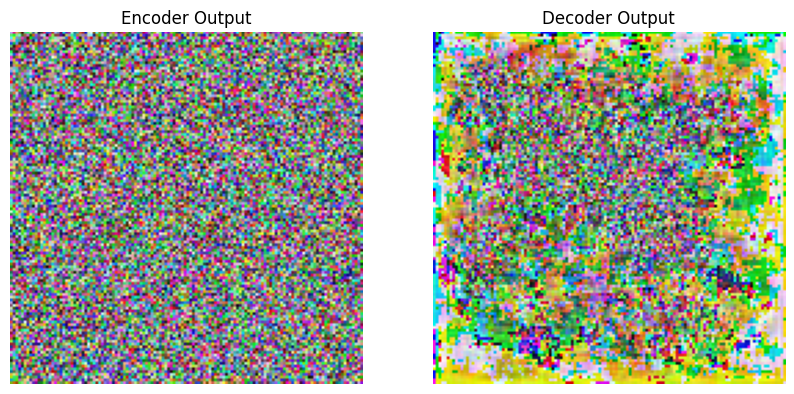

In [13]:
# Encoder
encoder_image = Image.fromarray(
    input_tensor[0].permute(1, 2, 0).mul(255).byte().cpu().numpy()
)

# Decoder
decoder_image = Image.fromarray(
    decoder_output[0].permute(1, 2, 0).mul(255).byte().cpu().numpy()
)

# Display side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(encoder_image)
axes[0].set_title("Encoder Output")
axes[0].axis("off")

axes[1].imshow(decoder_image)
axes[1].set_title("Decoder Output")
axes[1].axis("off")

plt.show()

## CLIP:  Text Encoder

### Embedding

In [14]:
class CLIPEmbedding(nn.Module):
    def __init__(self, n_vocab: int, n_embd: int, n_token: int):
        super().__init__()

        self.token_embedding = nn.Embedding(n_vocab, n_embd)
        self.position_embedding = nn.Parameter(torch.zeros(n_token, n_embd))

    def forward(self, tokens: torch.LongTensor) -> torch.LongTensor:
        # tokens: B S

        # B S ->  B S E
        x = self.token_embedding(tokens)

        x += self.position_embedding

        return x


### Layer

In [15]:
class CLIPLayer(nn.Module):
    def __init__(self, n_head: int, n_embd: int):
        super().__init__()
        self.layernorm_1 = nn.LayerNorm(n_embd)
        self.attention = SelfAttention(n_head, n_embd)
        self.layernorm_2 = nn.LayerNorm(n_embd)

        self.linear_1 = nn.Linear(n_embd, 4 * n_embd)
        self.linear_2 = nn.Linear(4 * n_embd, n_embd)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: B S E

        # ---------------------------------------------------- #
        # SELF ATTENTION
        residue = x

        # B S E -> B S E
        x = self.layernorm_1(x)
        # B S E -> B S E
        x = self.attention(x, causal_mask=True)

        # B S E -> B S E
        x += residue

        # ---------------------------------------------------- #
        # FEED FORWARD
        residue = x

        # B S E -> B S E
        x = self.layernorm_2(x)
        # B S E -> B S E*4
        x = self.linear_1(x)

        # QuickGELU activation function
        x = x * torch.sigmoid(1.702 * x)

        # B S E*4 -> B S E
        x = self.linear_2(x)

        # B S E -> B S E
        x += residue

        return x

### Model

In [16]:
class CLIP(nn.Module):
    def __init__(self):
        super().__init__()

        self.embedding = CLIPEmbedding(49408, 768, 77)
        self.layers = nn.ModuleList([CLIPLayer(12, 768) for _ in range(12)])

        self.layernorm = nn.LayerNorm(768)

    def forward(self, tokens: torch.LongTensor) -> torch.LongTensor:
        # tokens: B S
        tokens = tokens.type(torch.long)

        # B S -> B S E
        state = self.embedding(tokens)

        for layer in self.layers:
            # B S E -> B S E
            state = layer(state)

        # B S E -> B S E
        output = self.layernorm(state)

        return output

In [17]:
CLIP()(torch.randint(0, 49408, (10, 77))).shape

torch.Size([10, 77, 768])

## Diffusion (UNet)

### Time Embedding

In [18]:
class TimeEmbedding(nn.Module):
    def __init__(self, n_embd: int):
        super().__init__()

        self.linear_1 = nn.Linear(n_embd, n_embd * 4)
        self.linear_2 = nn.Linear(n_embd * 4, n_embd * 4)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (1, 320)

        x = self.linear_1(x)
        x = F.silu(x)
        x = self.linear_2(x)

        # x_out: (1, 1280)
        return x


### UNet

#### Upsample

In [19]:
class UNetUpsample(nn.Module):
    def __init__(self, channels: int):
        super().__init__()

        self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: B C H W

        # B C H W -> B C H*2 W*2
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        return self.conv(x)


#### Residual Block

In [20]:
class UNetResidualBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, n_time=1280):
        super().__init__()

        self.groupnorm_feature = nn.GroupNorm(32, in_channels)
        self.conv_feature = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, padding=1
        )
        self.linear_time = nn.Linear(n_time, out_channels)

        self.groupnorm_merged = nn.GroupNorm(32, out_channels)
        self.conv_merged = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, padding=1
        )

        if in_channels == out_channels:
            self.residual_layer = nn.Identity()
        else:
            self.residual_layer = nn.Conv2d(
                in_channels, out_channels, kernel_size=1, padding=0
            )

    def forward(self, feature: torch.Tensor, time: torch.Tensor) -> torch.Tensor:
        # feature: (B C_in H W)
        # time: (1, 1280)

        residue = feature

        feature = self.groupnorm_feature(feature)
        feature = F.silu(feature)
        # B C_in H W -> B C_out H W
        feature = self.conv_feature(feature)

        time = F.silu(time)
        # 1, 1280 -> 1, C_out
        time = self.linear_time(time)

        # B C_out H W + 1 C_out 1 1 -> B C_out H W
        merged = feature + time.unsqueeze(-1).unsqueeze(-1)
        merged = self.groupnorm_merged(merged)
        merged = F.silu(merged)
        merged = self.conv_merged(merged)

        return merged + self.residual_layer(residue)


#### Attention Block

In [21]:
class UNetAttentionBlock(nn.Module):
    def __init__(self, n_head: int, n_embd: int, d_context: int = 768):
        super().__init__()

        channels = n_head * n_embd

        self.groupnorm = nn.GroupNorm(32, channels, eps=1e-6)
        self.conv_input = nn.Conv2d(channels, channels, kernel_size=1, padding=0)

        self.layernorm_1 = nn.LayerNorm(channels)
        self.attention_1 = SelfAttention(n_head, channels, in_proj_bias=False)
        self.layernorm_2 = nn.LayerNorm(channels)
        self.attention_2 = CrossAttention(
            n_head, channels, d_context, in_proj_bias=False
        )
        self.layernorm_3 = nn.LayerNorm(channels)
        self.linear_geglu_1 = nn.Linear(channels, 4 * channels * 2)
        self.linear_geglu_2 = nn.Linear(4 * channels, channels)

        self.conv_output = nn.Conv2d(channels, channels, kernel_size=1, padding=0)

    def forward(self, x: torch.Tensor, context: torch.LongTensor) -> torch.Tensor:
        # x: B C H W
        # context: B S E

        residue_long = x

        x = self.groupnorm(x)
        x = self.conv_input(x)

        b, c, h, w = x.shape

        # B C H W -> B C H*W
        x = x.view(b, c, h * w)
        # B C H*W -> B H*W C
        x = x.transpose(-1, -2)

        # Normalization + Self-attention with residual connection
        residue_short = x
        x = self.layernorm_1(x)
        x = self.attention_1(x)

        x += residue_short

        # Normalization + Cross-attention with residual connection
        residue_short = x
        x = self.layernorm_2(x)
        x = self.attention_2(x, context)

        x += residue_short

        # Normalization + Feed-forward with GeGLU with residual connection
        residue_short = x

        x = self.layernorm_3(x)
        x, gate = self.linear_geglu_1(x).chunk(2, dim=-1)
        x = x * F.gelu(gate)

        x = self.linear_geglu_2(x)

        x += residue_short

        # B H*W C -> B C H*W
        x = x.transpose(-1, -2)
        # B C H*W -> B C H W
        x = x.view((b, c, h, w))

        return self.conv_output(x) + residue_long


#### SwitchSequential

In [22]:
class SwitchSequential(nn.Sequential):
    def forward(
        self, x: torch.Tensor, context: torch.LongTensor, time: torch.Tensor
    ) -> torch.Tensor:
        for layer in self:
            if isinstance(layer, UNetAttentionBlock):
                x = layer(x, context)
            elif isinstance(layer, UNetResidualBlock):
                x = layer(x, time)
            else:
                x = layer(x)

        return x


#### Model

In [23]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoders = nn.ModuleList(
            [
                # ---------------------------------------------------- #
                # B 4 H/8 W/8 -> B 320 H/8 W/8
                SwitchSequential(nn.Conv2d(4, 320, kernel_size=3, padding=1)),
                # ---------------------------------------------------- #
                # B 320 H/8 W/8 -> B 320 H/8 W/8
                SwitchSequential(
                    UNetResidualBlock(320, 320), UNetAttentionBlock(8, 40)
                ),
                SwitchSequential(
                    UNetResidualBlock(320, 320), UNetAttentionBlock(8, 40)
                ),
                # ---------------------------------------------------- #
                # B 320 H/8 W/8 -> B 320 H/16 W/16
                SwitchSequential(
                    nn.Conv2d(320, 320, kernel_size=3, padding=1, stride=2)
                ),
                # ---------------------------------------------------- #
                # B 320 H/16 W/16 -> B 640 H/16 W/16
                SwitchSequential(
                    UNetResidualBlock(320, 640), UNetAttentionBlock(8, 80)
                ),
                SwitchSequential(
                    UNetResidualBlock(640, 640), UNetAttentionBlock(8, 80)
                ),
                # ---------------------------------------------------- #
                # B 640 H/16 W/16 -> B 640 H/32 W/32
                SwitchSequential(
                    nn.Conv2d(640, 640, kernel_size=3, padding=1, stride=2)
                ),
                # ---------------------------------------------------- #
                # B 640 H/32 W/32 -> B 1280 H/32 W/32
                SwitchSequential(
                    UNetResidualBlock(640, 1280), UNetAttentionBlock(8, 160)
                ),
                SwitchSequential(
                    UNetResidualBlock(1280, 1280), UNetAttentionBlock(8, 160)
                ),
                # ---------------------------------------------------- #
                # B 1280 H/32 W/32 -> B 1280 H/64 W/64
                SwitchSequential(
                    nn.Conv2d(1280, 1280, kernel_size=3, padding=1, stride=2)
                ),
                SwitchSequential(UNetResidualBlock(1280, 1280)),
                SwitchSequential(UNetResidualBlock(1280, 1280)),
            ]
        )

        self.bottleneck = SwitchSequential(
            UNetResidualBlock(1280, 1280),
            UNetAttentionBlock(8, 160),
            UNetResidualBlock(1280, 1280),
        )

        self.decoders = nn.ModuleList(
            [
                # ---------------------------------------------------- #
                # B 2560 H/64 W/64 -> B 1280 H/64 W/64
                SwitchSequential(UNetResidualBlock(2560, 1280)),
                SwitchSequential(UNetResidualBlock(2560, 1280)),
                # ---------------------------------------------------- #
                # B 2560 H/64 W/64 -> B 1280 H/32 W/32
                SwitchSequential(UNetResidualBlock(2560, 1280), UNetUpsample(1280)),
                # ---------------------------------------------------- #
                # B 2560 H/32 W/32 -> B 1280 H/32 W/32
                SwitchSequential(
                    UNetResidualBlock(2560, 1280), UNetAttentionBlock(8, 160)
                ),
                SwitchSequential(
                    UNetResidualBlock(2560, 1280), UNetAttentionBlock(8, 160)
                ),
                # ---------------------------------------------------- #
                # B 1920 H/32 W/32 -> B 1280 H/16 W/16
                SwitchSequential(
                    UNetResidualBlock(1920, 1280),
                    UNetAttentionBlock(8, 160),
                    UNetUpsample(1280),
                ),
                # ---------------------------------------------------- #
                # B 1920 H/16 W/16 -> B 640 H/16 W/16
                SwitchSequential(
                    UNetResidualBlock(1920, 640), UNetAttentionBlock(8, 80)
                ),
                # ---------------------------------------------------- #
                # B 1280 H/16 W/16 -> B 640 H/16 W/16
                SwitchSequential(
                    UNetResidualBlock(1280, 640), UNetAttentionBlock(8, 80)
                ),
                # ---------------------------------------------------- #
                # B 960 H/16 W/16 -> B 640 H/8 W/8
                SwitchSequential(
                    UNetResidualBlock(960, 640),
                    UNetAttentionBlock(8, 80),
                    UNetUpsample(640),
                ),
                # ---------------------------------------------------- #
                # B 960 H/8 W/8 -> B 320 H/8 W/8
                SwitchSequential(
                    UNetResidualBlock(960, 320), UNetAttentionBlock(8, 40)
                ),
                # ---------------------------------------------------- #
                # B 640 H/8 W/8 -> B 320 H/8 W/8
                SwitchSequential(
                    UNetResidualBlock(640, 320), UNetAttentionBlock(8, 40)
                ),
                SwitchSequential(
                    UNetResidualBlock(640, 320), UNetAttentionBlock(8, 40)
                ),
            ]
        )

    def forward(
        self, x: torch.Tensor, context: torch.LongTensor, time: torch.Tensor
    ) -> torch.Tensor:
        # x: B 4 H/8 W/8
        # context: B S E
        # time: (1, 1280)

        residual_connections = []

        for layer in self.encoders:
            x = layer(x, context, time)
            residual_connections.append(x)

        x = self.bottleneck(x, context, time)

        for layer in self.decoders:
            x = torch.cat((x, residual_connections.pop()), dim=1)
            x = layer(x, context, time)

        return x

#### Output

In [24]:

class UNetOutput(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        self.groupnorm = nn.GroupNorm(32, in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: B 320 H/8 W/8

        x = self.groupnorm(x)
        x = F.silu(x)

        # B 320 H/8 W/8 -> B 4 H/8 W/8
        x = self.conv(x)

        return x


### Model

In [25]:
class Diffusion(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_embedding = TimeEmbedding(320)
        self.unet = UNet()
        self.final = UNetOutput(320, 4)

    def forward(
        self, latent: torch.Tensor, context: torch.LongTensor, time: torch.Tensor
    ):
        # latent: B 4 H/8 W/8
        # context: B S E
        # time: (1, 320)

        # (1, 320) -> (1, 1280)
        time = self.time_embedding(time)

        # B 4 H/8 W/8 -> B 320 H/8 W/8
        output = self.unet(latent, context, time)

        # B 320 H/8 W/8 -> # B 4 H/8 W/8
        output = self.final(output)

        return output

### Test

In [26]:
# Create random input tensors
input_tensor = torch.randn(4, 4, 16, 16)

output_tensor = Diffusion()(input_tensor, torch.randn(4, 77, 768), torch.randn(1, 320))

print(output_tensor.shape)

torch.Size([4, 4, 16, 16])

## Scheduler

In [27]:
class DDPMSampler:
    def __init__(
        self,
        generator: torch.Generator,
        n_training_steps: int = 1000,
        min_beta: float = 0.00085,
        max_beta: float = 0.0120,
    ):
        self.betas = (
            torch.linspace(
                min_beta**0.5, max_beta**0.5, n_training_steps, dtype=torch.float32
            )
            ** 2
        )

        self.alphas = 1.0 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

        self.ones = torch.tensor(1.0)

        self.n_training_steps = n_training_steps
        self.generator = generator
        self.timesteps = torch.from_numpy(np.arange(0, n_training_steps)[::-1].copy())

    def set_inference_timesteps(self, n_inference_steps: int = 50):
        self.n_inference_steps = n_inference_steps

        step_ratio = self.n_training_steps // self.n_inference_steps

        # Define the timesteps to use for inference
        timesteps = (
            (np.arange(0, n_inference_steps) * step_ratio)
            .round()[::-1]
            .copy()
            .astype(np.int64)
        )
        self.timesteps = torch.from_numpy(timesteps)

    def _get_previous_timestep(self, timestep: int) -> int:
        prev_t = timestep - (self.n_training_steps // self.n_inference_steps)
        return prev_t

    def _get_variance(self, timestep: int) -> torch.Tensor:
        prev_t = self._get_previous_timestep(timestep)

        alpha_bar_t = self.alpha_bars[timestep]
        alpha_bar_prev_t = self.alpha_bars[prev_t] if prev_t >= 0 else self.ones

        current_beta_t = 1 - alpha_bar_t / alpha_bar_prev_t

        variance = (1 - alpha_bar_prev_t) / (1 - alpha_bar_t) * current_beta_t

        variance = variance.clamp(min=1e-20)

        return variance
    
    # TBD: _set_strength (img2img)

    def add_noise(
        self, x: torch.FloatTensor, timestep: torch.IntTensor
    ) -> torch.FloatTensor:
        """
        Add noise to an input tensor x at a given timestep t
        """

        alpha_bars = self.alpha_bars.to(device=x.device, dtype=x.dtype)
        timestep = timestep.to(x.device)

        sqrt_alpha_bars = alpha_bars[timestep] ** 0.5
        sqrt_alpha_bars = sqrt_alpha_bars.flatten()

        # Repeat the sqrt_alpha_bars tensor to match the input tensor shape
        while len(sqrt_alpha_bars.shape) < len(x.shape):
            sqrt_alpha_bars = sqrt_alpha_bars.unsqueeze(-1)

        sqrt_one_minus_alpha_bars = (self.ones - alpha_bars[timestep]) ** 0.5
        sqrt_one_minus_alpha_bars = sqrt_one_minus_alpha_bars.flatten()

        # Repeat the sqrt_one_minus_alpha_bars tensor to match the input tensor shape
        while len(sqrt_one_minus_alpha_bars.shape) < len(x.shape):
            sqrt_one_minus_alpha_bars = sqrt_one_minus_alpha_bars.unsqueeze(-1)

        noise = torch.randn(
            x.shape, generator=self.generator, device=x.device, dtype=x.dtype
        )

        mean = sqrt_alpha_bars * x
        std_dev = sqrt_one_minus_alpha_bars

        noisy_samples = mean + std_dev * noise

        return noisy_samples

    def step(self, timestep: int, latent: torch.Tensor, model_output: torch.Tensor):
        t = timestep
        prev_t = self._get_previous_timestep(t)

        alpha_bar_t = self.alpha_bars[t]
        alpha_bar_prev_t = self.alpha_bars[prev_t] if prev_t >= 0 else self.ones

        beta_t = 1 - alpha_bar_t
        beta_prev_t = 1 - alpha_bar_prev_t

        # Compute the predicted original sample
        x0_pred = (latent - beta_t**0.5) * model_output * (1 / alpha_bar_t**0.5)

        # Compute mean and variance of the posterior
        mean = ((alpha_bar_prev_t**0.5 * beta_t) / beta_t * x0_pred) + (
            (alpha_bar_t**0.5 * beta_prev_t) / beta_t
        ) * latent

        std_dev = 0

        if t > 0:
            noise = torch.randn(
                model_output.shape,
                generator=self.generator,
                device=model_output.device,
                dtype=model_output.dtype,
            )

            std_dev = self._get_variance(t) ** 0.5 * noise

        mean = mean + std_dev

        return mean


In [28]:
sampler = DDPMSampler(torch.Generator(), n_training_steps=1000)
sampler

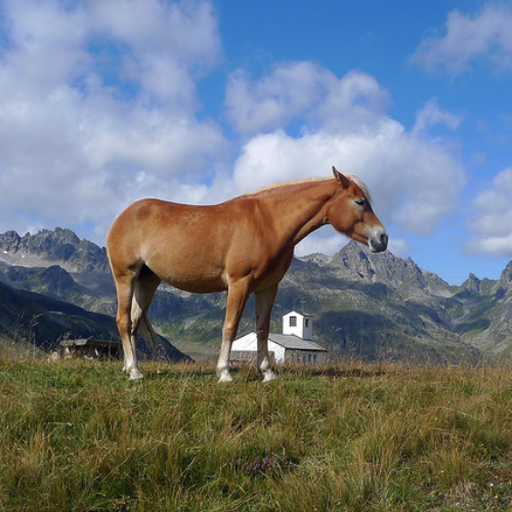

In [44]:
sample_image = Image.open("images/sample.png")

sample_image

In [50]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

reverse_transform = transforms.Compose([
    transforms.ToPILImage(),
])

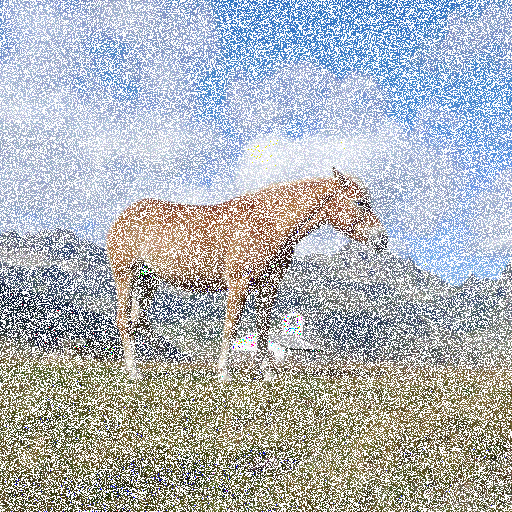

In [51]:
noisy_sample = sampler.add_noise(transform(sample_image), torch.tensor(0))

reverse_transform(noisy_sample)

## Generate

In [52]:
WIDTH = 512
HEIGHT = 512

LATENT_WIDTH = WIDTH // 8
LATENT_HEIGHT = HEIGHT // 8

In [53]:
def rescale(x, input_range, output_range, clamp=False):
    input_min, input_max = input_range
    output_min, output_max = output_range

    x -= input_min
    x *= (output_max - output_min) / (input_max-input_min)
    x += output_max

    if clamp:
        x = x.clamp(output_min, output_max)

    return x


In [54]:
def get_time_embedding(timestep):
    # (160, )
    freqs = torch.pow(10000, -torch.arange(0, 160, dtype=torch.float32) / 160)

    # (1, 160)
    x = torch.tensor([timestep], dtype=torch.float32)[:, None] * freqs[None]

    # (1, 160) -> (1, 320)
    x = torch.cat([torch.cos(x), torch.sin(x)], dim=-1)

    return x


In [55]:
def generate(
    prompt,
    negative_prompt=None,
    input_image=None,
    strength=0.8,
    do_cfg=True,
    cfg_scale=7.5,
    sampler_name="ddpm",
    n_inference_steps=50,
    models={},
    seed=None,
    device=None,
    idle_device=None,
    tokenizer=None,
):
    with torch.no_grad():
        # Initialize inference pipeline parameters
        if not (0 <= strength < 1):
            raise ValueError("Strength must be between 0 and 1")

        def to_idle(x):
            return x.to(idle_device) if idle_device is not None else x

        generator = torch.Generator(device=device)

        if seed is None:
            generator.seed()

        else:
            generator.manual_seed(seed)

        # Convert input prompt to embeddings using CLIP
        clip: CLIP = models["clip"]
        clip.to(device)

        conditional_tokens = tokenizer.batch_encode_plus(
            [prompt], padding="max_length", max_length=77
        ).input_ids

        # B S
        conditional_tokens = torch.tensor(
            conditional_tokens, dtype=torch.long, device=device
        )

        # B S -> B S E
        condtional_context = clip(conditional_tokens)

        if do_cfg:
            # If classifier-free guidance is enabled
            # Convert negative prompt to embeddings using CLIP and concatenate with original prompt embeddings

            unconditional_tokens = tokenizer.batch_encode_plus(
                [negative_prompt], padding="max_length", max_length=77
            ).input_ids

            # B S
            unconditional_tokens = torch.tensor(
                unconditional_tokens, dtype=torch.long, device=device
            )

            # B S -> B S E
            unconditional_context = clip(unconditional_tokens)

            # B S E -> 2*B S E
            context = torch.cat([condtional_context, unconditional_context], dim=0)

        else:
            # B S E -> B S E
            context = condtional_context

        # Move CLIP back to idle device
        to_idle(clip)

        if sampler_name == "ddpm":
            sampler = DDPMSampler(generator)
            sampler.set_inference_timesteps(n_inference_steps)
        else:
            raise ValueError(f"Sampler {sampler_name} not found")

        # B 4 H/8 W/8
        latents_shape = (1, 4, LATENT_HEIGHT, LATENT_WIDTH)

        # ---------------------------------------------------- #
        # TBD: img2img
        # ---------------------------------------------------- #

        # ---------------------------------------------------- #
        # txt2img
        # ---------------------------------------------------- #

        # Start with random noise
        latents = torch.randn(latents_shape, device=device, generator=generator)

        diffusion = models["diffusion"]
        diffusion.to(device)

        # Run generation loop
        for i, timestep in enumerate(tqdm(sampler.timesteps)):
            # 1 -> 1, 320
            time_embedding = get_time_embedding(timestep).to(device)

            # B 4 H/8 W/8
            model_input = latents

            if do_cfg:
                # B 4 H/8 W/8 -> 2*B 4 H/8 W/8
                model_input = model_input.repeat(2, 1, 1, 1)

            # Get predicted noise
            # B 4 H/8 W/8, B S E, 1 320 -> B 4 H/8 W/8
            model_output = diffusion(model_input, context, time_embedding)

            if do_cfg:
                # 2*B 4 H/8 W/8 -> B 4 H/8 W/8, B 4 H/8 W/8
                output_cond, output_uncond = model_output.chunk(2, dim=0)
                model_output = (output_cond - output_uncond) * cfg_scale + output_uncond

            # Remove predicted noise from the latent tensor
            latents = sampler.step(timestep, latents, model_output)

        to_idle(diffusion)

        # Pass generated latent tensor through the decoder to get the final image
        decoder = models["decoder"]
        decoder.to(device)

        # B 4 H/8 W/8 -> B 3 H W
        generated_image = decoder(latents)
        to_idle(decoder)

        # Reverse normalization
        generated_image = rescale(generated_image, (-1, 1), (0, 255), clamp=True)
        # B 3 H W -> B H W 3
        generated_image = (
            generated_image.permute(0, 2, 3, 1).to("cpu", torch.uint8).numpy()
        )
        return generated_image[0]